In [1]:
! pip install langchain langchain-openai langchain-community langgraph python-dotenv faiss-cpu pypdf

  Using cached langchain-1.2.10-py3-none-any.whl.metadata (5.7 kB)
  Using cached langchain_openai-1.1.10-py3-none-any.whl.metadata (3.1 kB)
  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
  Using cached langchain_core-1.2.16-py3-none-any.whl.metadata (4.4 kB)
  Using cached pydantic-2.12.5-py3-none-any.whl.metadata (90 kB)
  Using cached openai-2.24.0-py3-none-any.whl.metadata (29 kB)
  Using cached langchain_classic-1.0.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tenacity-9.1.4-py3-none-any.whl.metadata (1.2 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached langgraph_prebuilt-1.0.8-py3-none-any.whl.metadata (5.2 kB)
  Using cached langgraph_sdk-0.3.9-py3-none-any.whl.metadata (1.6 kB)
  Using cached aiohappyeye


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langgraph.graph import StateGraph,START,END,add_messages
from typing import TypedDict,Annotated,List
from langchain_core.messages import BaseMessage,HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv

In [2]:
model = ChatOpenAI()

embedding = OpenAIEmbeddings()

load_dotenv()

True

In [3]:
path = 'Building Machine Learning Systems with Python - Second Edition.pdf'
loader = PyPDFLoader(path)
docs = loader.load()

In [4]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200
)
chunks = splitter.split_documents(docs)

In [5]:
vector_store = FAISS.from_documents(
    embedding = embedding,
    documents = chunks
)

In [6]:
retriever = vector_store.as_retriever(
    search_type = 'mmr',
    search_kwargs = {'k':4}
)

In [7]:
@tool
def rag_tool(query):
    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """

    results = retriever.invoke(query)
    content = [doc.page_content for doc in results]
    metadata = [doc.metadata for doc in results]

    return {
        'query':query,
        'content':content,
        'metadata':metadata
    }

In [8]:
class RAG(TypedDict):

    messages : Annotated[List[BaseMessage],add_messages]

In [9]:
tool_kit = [rag_tool]

model_with_tools = model.bind_tools(tool_kit)

def chat_node(state:RAG)->dict:
    
    messages = state['messages']

    response = model_with_tools.invoke(messages)

    return {'messages':[response]}

In [10]:
tools = ToolNode(tool_kit)

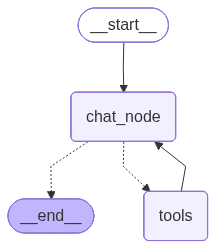

In [11]:
graph = StateGraph(RAG)

graph.add_node('chat_node',chat_node)
graph.add_node('tools',tools)

graph.add_edge( START,'chat_node')
graph.add_conditional_edges('chat_node',tools_condition)
graph.add_edge('tools','chat_node')

chat = graph.compile()

chat

In [17]:
response = chat.invoke({'messages':[HumanMessage(content='What is Linear Regression')]})

print(response['messages'][-1].content)

Linear regression is a method used in machine learning for modeling the relationship between a dependent variable (target) and one or more independent variables (features). It is a simple and commonly used approach for predictive modeling.

In linear regression, the goal is to find the best-fitting linear relationship between the independent variables and the dependent variable. This relationship is represented by a linear equation of the form:

\[ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n \]

where:
- \( y \) is the dependent variable (target),
- \( x_1, x_2, ..., x_n \) are the independent variables (features),
- \( \beta_0, \beta_1, \beta_2, ..., \beta_n \) are the coefficients that need to be estimated,
- The goal is to find the coefficients that minimize the difference between the observed values and the values predicted by the model.

Linear regression is often used for tasks such as prediction, forecasting, and understanding the relationship between variables. 